In [1]:
from argparse import Namespace
from torch.nn import ModuleDict
from model.DeepVSLNet_cbkd import TeacherVSLNetCBDK, build_optimizer_and_scheduler
from utils.cbkd_helpers import prune_block4, prune_block3, prune_block2
from utils.cbkd_config import CBKDConfig

from copy import deepcopy

c:\Users\andre\Documents\University\1st Year\Machine Learning and Deep Learning\Ego4D-NLQ\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def count_params(model, trainable=False):
    total = sum(p.numel() for p in model.parameters()
                               if (p.requires_grad or not trainable))
    return total

In [3]:
configs = Namespace(
    video_feature_dim=256,
    dim=256,
    film_mode="inside_encoder:multi",
    drop_rate=0,
    word_size=300,
    char_size=1000,
    word_dim=300,
    char_dim=50,
    word_vectors=None,
    num_heads=8,
    max_pos_len=128,
    predictor="glove",
)

cbkd_config = CBKDConfig()

model = TeacherVSLNetCBDK(configs=configs, word_vectors=None)
student = deepcopy(model)

In [4]:
teacher_params  = count_params(model.block1, trainable=False)
student_params  = count_params(model.block1,  trainable=False)

print(f"Teacher Block 1: {teacher_params/1e6:7.3f} M params "
      f"({teacher_params*4/1024**2:.1f} MB fp32)")
print(f"Student Block 1: {student_params/1e6:7.3f} M params "
      f"({student_params*4/1024**2:.1f} MB fp32)")

reduction = 100 * (1 - student_params / teacher_params)
print(f"Parameter reduction: {reduction:.2f}%")

Teacher Block 1:   0.324 M params (1.2 MB fp32)
Student Block 1:   0.324 M params (1.2 MB fp32)
Parameter reduction: 0.00%


In [5]:
student_2 = deepcopy(model.block2)
pruned_block2 = prune_block2(student_2["feature_encoder"], keep_ratio_ds=cbkd_config.keep_ratio_block2_ds, keep_ratio_attn=cbkd_config.keep_ratio_block2_attn)
C = ModuleDict({"feature_encoder": pruned_block2})

teacher_params  = count_params(student_2, trainable=False)
student_params  = count_params(pruned_block2,  trainable=False)

print(f"Teacher Block 2: {teacher_params/1e6:7.3f} M params "
      f"({teacher_params*4/1024**2:.1f} MB fp32)")
print(f"Student Block 2: {student_params/1e6:7.3f} M params "
      f"({student_params*4/1024**2:.1f} MB fp32)")

reduction = 100 * (1 - student_params / teacher_params)
print(f"Parameter reduction: {reduction:.2f}%")

Teacher Block 2:   0.964 M params (3.7 MB fp32)
Student Block 2:   0.500 M params (1.9 MB fp32)
Parameter reduction: 48.13%


In [6]:
student_3 = deepcopy(model.block3)
pruned_block3 = prune_block3(teacher_block3=student_3, keep_ratio_cqa=cbkd_config.keep_ratio_block3_cqa, keep_ratio_concat=cbkd_config.keep_ratio_block3_concat)

teacher_params  = count_params(student_3, trainable=False)
student_params  = count_params(pruned_block3,  trainable=False)

print(f"Teacher Block 3: {teacher_params/1e6:7.3f} M params "
      f"({teacher_params*4/1024**2:.1f} MB fp32)")
print(f"Student Block 3: {student_params/1e6:7.3f} M params "
      f"({student_params*4/1024**2:.1f} MB fp32)")

reduction = 100 * (1 - student_params / teacher_params)
print(f"Parameter reduction: {reduction:.2f}%")

Teacher Block 3:   0.395 M params (1.5 MB fp32)
Student Block 3:   0.199 M params (0.8 MB fp32)
Parameter reduction: 49.72%


In [7]:
student_4 = deepcopy(model.block4)
pruned_block4 = prune_block4(teacher_block4=student_4, keep_ratio_enc=cbkd_config.keep_ratio_block4_enc, keep_ratio_pred=cbkd_config.keep_ratio_block4_pred)

teacher_params  = count_params(student_4, trainable=False)
student_params  = count_params(pruned_block4,  trainable=False)

print(f"Teacher Block 4: {teacher_params/1e6:7.3f} M params "
      f"({teacher_params*4/1024**2:.1f} MB fp32)")
print(f"Student Block 4: {student_params/1e6:7.3f} M params "
      f"({student_params*4/1024**2:.1f} MB fp32)")

reduction = 100 * (1 - student_params / teacher_params)
print(f"Parameter reduction: {reduction:.2f}%")

Teacher Block 4:   1.228 M params (4.7 MB fp32)
Student Block 4:   0.502 M params (1.9 MB fp32)
Parameter reduction: 59.09%


In [8]:
student.block2 = pruned_block2
student.block3 = pruned_block3
student.block4 = pruned_block4

teacher_params  = count_params(model, trainable=False)
student_params  = count_params(student,  trainable=False)

print(f"Teacher : {teacher_params/1e6:7.3f} M params "
      f"({teacher_params*4/1024**2:.1f} MB fp32)")
print(f"Student : {student_params/1e6:7.3f} M params "
      f"({student_params*4/1024**2:.1f} MB fp32)")

reduction = 100 * (1 - student_params / teacher_params)
print(f"Parameter reduction: {reduction:.2f}%")

Teacher :   2.911 M params (11.1 MB fp32)
Student :   1.525 M params (5.8 MB fp32)
Parameter reduction: 47.62%


STANDARD DISTILLATION

In [9]:
from argparse import Namespace
from torch.nn import ModuleDict
from model.DeepVSLNet_cbkd import TeacherVSLNetCBDK, build_optimizer_and_scheduler
from model.DeepVSLNet import DeepVSLNet
from model.LightVSLNet import LightVSLNet
from utils.cbkd_helpers import prune_block4, prune_block3, prune_block2
from utils.cbkd_config import CBKDConfig

from copy import deepcopy

In [10]:
def count_params(model, trainable=False):
    total = sum(p.numel() for p in model.parameters()
                               if (p.requires_grad or not trainable))
    return total

In [11]:
configs_teacher = Namespace(
    video_feature_dim=256,
    dim=256,
    film_mode="inside_encoder:multi",
    drop_rate=0,
    word_size=300,
    char_size=1000,
    word_dim=300,
    char_dim=50,
    word_vectors=None,
    num_heads=8,
    max_pos_len=128,
    predictor="glove",
)

configs_student = Namespace(
    video_feature_dim=256,
    dim=256,
    film_mode="inside_encoder:multi",
    drop_rate=0,
    word_size=300,
    char_size=1000,
    word_dim=300,
    char_dim=50,
    word_vectors=None,
    num_heads=8,
    max_pos_len=128,
    predictor="glove",
    dim_student=16,
    num_heads_student=2
)

cbkd_config = CBKDConfig()

model = DeepVSLNet(configs=configs_teacher, word_vectors=None)
student = LightVSLNet(configs=configs_student, word_vectors=None)

In [12]:
teacher_params  = count_params(model, trainable=False)
student_params  = count_params(student,  trainable=False)

print(f"Teacher : {teacher_params/1e6:7.3f} M params "
      f"({teacher_params*4/1024**2:.1f} MB fp32)")
print(f"Student : {student_params/1e6:7.3f} M params "
      f"({student_params*4/1024**2:.1f} MB fp32)")

reduction = 100 * (1 - student_params / teacher_params)
print(f"Parameter reduction: {reduction:.2f}%")

Teacher :   3.043 M params (11.6 MB fp32)
Student :   0.312 M params (1.2 MB fp32)
Parameter reduction: 89.75%


In [13]:
import matplotlib.pyplot as plt

def kd_tradeoff_plot(gflops, accs, params_m, labels,
                     title="Model trade-off", xlim=None, ylim=None):
    palette = ["dodgerblue","mediumturquoise","gold","crimson",
               "orchid","steelblue","limegreen","lightsalmon"]
    sizes   = [p * 250 for p in params_m]

    plt.figure(figsize=(7,4.5))
    for i,(x,y,s,p,lab) in enumerate(zip(gflops, accs, sizes, params_m, labels)):
        plt.scatter(x, y, s=s, color=palette[i%len(palette)],
                    alpha=0.7, edgecolors='none', label=lab)
        plt.text(x, y+0.22, f"{p:.2f}M", ha='center', va='bottom', fontsize=9)

    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.xlabel("GFLOPs", fontsize=11)
    plt.ylabel("accuracy(%)", fontsize=11)
    plt.title(title, fontsize=14, weight="bold")
    if xlim: plt.xlim(*xlim)
    if ylim: plt.ylim(*ylim)

    lgd = plt.legend(frameon=False, fontsize=9, loc='lower right')
    # Robust bubble-resize across matplotlib versions
    handles = getattr(lgd, "legendHandles",
                      getattr(lgd, "legend_handles", []))
    for h in handles:
        h.set_sizes([80])

    plt.tight_layout()
    plt.show()


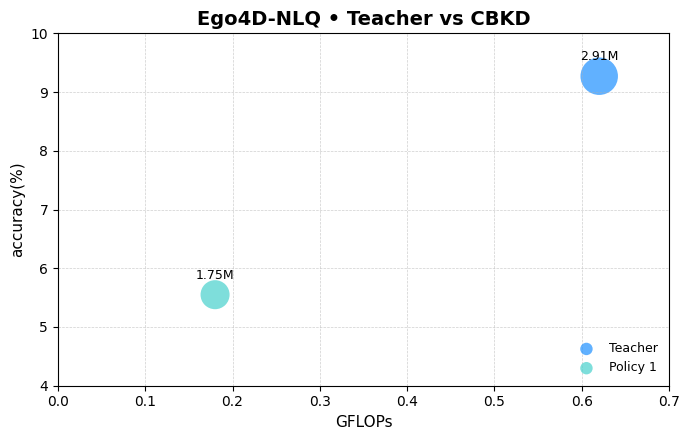

In [14]:
gflops   = [0.62, 0.18]
accs     = [9.27, 5.55]
params_m = [2.911, 1.748]
labels   = ["Teacher", "Policy 1"]

kd_tradeoff_plot(gflops, accs, params_m, labels,
                 title="Ego4D-NLQ • Teacher vs CBKD",
                 xlim=(0,0.7), ylim=(4,10))
